Railway Knowledge System
===

Ren Nakagawa

---

## Components
- GPT4o - mini
- ReAct
  - RAG with fasis (鉄道に関する技術上の基準を定める省令)
  - RAG with fasis (鉄道事故報告書)
  - Code Interpleter(Math Calculator)
  - Text Exstractor
  - Search with duckduckgo

In [ ]:
IS_ALL_RUN = False

# Set up

In [ ]:
!git clone https://github.com/rakawanegan/pbl-railway-knowledge-system
%cd pbl-railway-knowledge-system
%pip install transformers faiss-gpu fugashi ipadic openai langchain langchain-community unidic_lite >> install.txt

Cloning into 'pbl-railway-knowledge-system'...
remote: Enumerating objects: 249, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 249 (delta 9), reused 26 (delta 5), pack-reused 218 (from 1)
Receiving objects: 100% (249/249), 5.07 MiB | 6.72 MiB/s, done.
Resolving deltas: 100% (115/115), done.
/content/pbl-railway-knowledge-system


In [ ]:
import os
import sys
import io
import re
import subprocess
from openai import OpenAI
from google.colab import userdata
from tqdm import tqdm
import time
import pandas as pd
import requests
from contextlib import contextmanager
from langchain.llms import OpenAI
from langchain.chat_models import ChatOpenAI
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
from langchain.agents import initialize_agent, AgentType
from langchain.agents import Tool

from src.main import MakeRailwayKnowledgePromptWithTohokuBERT as MakeRailwayKnowledgePrompt
from src.main import MakeRailwayIncidentCasePromptWithTohokuBERT as MakeRailwayIncidentPrompt

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

# Set up OpenAI API key
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')

# Initialize the OpenAI chat model
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

@contextmanager
def timer(name):
    t0 = time.time()
    yield
    print(f'[{name}] done in {time.time() - t0:.0f} s')

<ipython-input-3-2af3db27d0e7>:30: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)


In [ ]:
from functools import wraps

tool_usage_counts = dict()

def count_tool_usage(tool_name):
    def decorator(func):
        @wraps(func)
        def wrapper(*args, **kwargs):
            if tool_name not in tool_usage_counts:
                tool_usage_counts[tool_name] = 0
            tool_usage_counts[tool_name] += 1
            return func(*args, **kwargs)
        return wrapper
    return decorator

In [ ]:
k = 3
mrkp = MakeRailwayKnowledgePrompt(k=k)
mrip = MakeRailwayIncidentPrompt(k=k)

@count_tool_usage("DuckDuckGoSearch")
def duckduckgo_search(query: str) -> str:
    search_url = "https://api.duckduckgo.com/"
    params = {
        "q": query,
        "format": "json",
        "pretty": 1,
    }
    response = requests.get(search_url, params=params)
    response.raise_for_status()
    search_results = response.json()
    related_topics = search_results.get("RelatedTopics", [])
    formatted_results = ""
    for topic in related_topics[:5]:
        if 'Text' in topic and 'FirstURL' in topic:
            formatted_results += f"Title: {topic['Text']}\nURL: {topic['FirstURL']}\n\n"
    return formatted_results or "No relevant results found."


# OpenAI provide same function but that is too expensive.($0.03 per session)
@count_tool_usage("Code")
def execute_code(code: str):
    match = re.search(r"```(python|sh|bash|zsh|fish|cmd|powershell)\n(.*?)```", code, re.DOTALL)
    if not match:
        return "Error: No supported code block found."

    code_type = match.group(1)  # （python, sh, bash, zsh, fish, cmd, powershell）
    code_to_execute = match.group(2)

    if code_type == "python":
        stdout = sys.stdout
        sys.stdout = io.StringIO()
        try:
            exec(code_to_execute)
            output = sys.stdout.getvalue()
        except Exception as e:
            output = f"Error: {e}"
        finally:
            sys.stdout = stdout
    else:
        shell = True if code_type in ["sh", "bash", "zsh", "fish"] else False
        executable = {"cmd": "cmd.exe", "powershell": "powershell.exe"}.get(code_type)
        try:
            result = subprocess.run(
                code_to_execute,
                shell=shell,
                capture_output=True,
                text=True,
                executable=executable
            )
            output = result.stdout if result.returncode == 0 else f"Error: {result.stderr}"
        except Exception as e:
            output = f"Error: {e}"

    return output


def contains_word(text, word):
    pattern = re.compile(re.escape(word))
    return bool(pattern.search(text))


@count_tool_usage("RawText")
def search_word(word):
    positions_with_context = [sent for sent in mrkp.sentences if contains_word(sent, word)]
    search_result = '\n'.join(positions_with_context)
    return search_result


@count_tool_usage("KnowledgeRAG")
def get_knowledge(query):
    basis = mrkp.get_basis(query)
    return basis


@count_tool_usage("IncidentRAG")
def get_incident(query):
    basis = mrip.get_basis(query)
    return basis


search_tool = Tool(
    name="DuckDuckGoSearch",
    func=duckduckgo_search,
    description="一般情報を取得したい場合には、DuckDuckGoを使用してウェブ検索を行うことができます。"
)
raw_text_tool = Tool(
    name="RawText",
    func=search_word,
    description="鉄道に関する専門的な知識を取得したい場合には、鉄道に関する技術上の基準を定める省令から単語を指定して文章を抽出することができます。"
)
knowledge_rag_tool = Tool(
    name="KnowledgeRAG",
    func=get_knowledge,
    description="鉄道に関する専門的な知識を取得したい場合には、鉄道に関する技術上の基準を定める省令から類似する文章を検索することができます。"
)
incident_rag_tool = Tool(
    name="IncidentRAG",
    func=get_incident,
    description="鉄道に関する具体的な事例に対して、事故報告書から類似する事例を検索することができます。"
)
code_tool = Tool(
    name='Code',
    func=execute_code,
    description=(
        "Pythonやシェルでコードを実行する必要がある場合、このツールを使用します。"
        "例えば、今日の日付を取得したり、シェルコマンドを実行したりする際に利用します。"
        "コードを提供する場合、Markdown形式のコードブロックを使用し、"
        "トリプルバッククォートと共に言語識別子（例: ```python や ```sh）を指定してください。"
        "また、Pythonコードを実行する際には、print関数を使用して結果が表示されるようにしてください。"
    )
)
tools = [
    search_tool,
    raw_text_tool,
    knowledge_rag_tool,
    incident_rag_tool,
    code_tool,
]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/120 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/258k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

In [ ]:
# Define the prompt template for the ReAct agent
react_prompt = """
あなたは、推論して行動を起こす能力を備えた知的なエージェントです。
まず各タスクをステップごとに推論し、次にアクションが必要かどうかを決定します。
また、言語は日本語で回答し、最終的な答えには根拠も添えてください。

次のツールにアクセスできます:
{tools}

タスクが与えられたら、次のように応答します:
- "Thought:" 推論プロセスに進んでください。
- "Action:" アクションを実行する必要がある場合は、ツールからアクションを指定し実行してください。
- Otherwise, 最終的な答えに達するまで推論を続けてください。

タスク:
{task}

出力:
"""
prompt = PromptTemplate(
    input_variables=["task", "tools"],
    template=react_prompt,
)

In [ ]:
agent = initialize_agent(
    llm=llm,
    tools=tools,
    prompt=prompt,
    verbose=True,
    handle_parsing_errors=True,
    max_iterations=10,
    early_stopping_method="generate",
)

<ipython-input-7-a2b6790e722c>:1: LangChainDeprecationWarning: The function `initialize_agent` was deprecated in LangChain 0.1.0 and will be removed in 1.0. Use :meth:`~Use new agent constructor methods like create_react_agent, create_json_agent, create_structured_chat_agent, etc.` instead.
  agent = initialize_agent(


In [ ]:
def inference(question):
    try:
        output = agent.run(question)
    except Exception as e:
        output = f"Error: {e}"
    return output

In [ ]:
def evaluate_by_llm_with_criteria(pred, answer, llm, question=None, criteria_with_weights=None):
    """
    LLMでの評価を実行し、指定された重みに基づいてスコアを計算する関数。

    Parameters:
    pred (str): 採点対象の答案。
    answer (str): 正解または模範解答。
    llm (LLM): 使用する言語モデル。
    question (str, optional): 問題文。デフォルトはNone。
    criteria_with_weights (list of dict): 評価基準、重み、説明を含むリスト。
        例: [{"criterion": "妥当性", "weight": 0.3, "description": "詳細な説明文"}, ...]

    Returns:
    dict: 評価結果を含む辞書。
    """
    if criteria_with_weights is None:
        raise ValueError("評価基準と重みを含むリストまたは辞書を指定してください。")

    # Normalize weights
    total_weight = sum(item['weight'] for item in criteria_with_weights)
    for item in criteria_with_weights:
        item['weight'] /= total_weight

    base_prompt_template = """
    # 評価基準
    以下の基準に従い、問題と解答を参照しながら答案を採点してください。
    各項目について0〜5点のスコアを付け、理由を添えてください。
    スコアについて、0点は全く正確でない場合、3点は一部正確だが誤りも含む場合、5点は完全に正確である場合とします。

    採点項目: {criterion_description}

    # 無視事項
    以下の内容については採点不要です。
    - 他の評価基準
    - 問題文や解答の情報

    # 注意点
    データが見つからなかったという文言やエラー文が含まれている文章はスコアを0点にしてください。
    スコアの箇所は必ず【】で囲って明示してください。スコア以外の部分には【】を使用しないでください。
    """

    scores = {}
    feedbacks = []

    for item in criteria_with_weights:
        criterion = item['criterion']
        description = item['description']
        weight = item['weight']

        prompt_template = base_prompt_template.format(criterion_description=description)

        if question is not None:
            prompt = PromptTemplate(
                input_variables=["pred", "answer", "question"],
                template=f"""
                問題: "{{question}}"
                答案: "{{pred}}"
                解答: "{{answer}}",
                {prompt_template}
                """
            )
        else:
            prompt = PromptTemplate(
                input_variables=["pred", "answer"],
                template=f"""
                答案: "{{pred}}"
                解答: "{{answer}}",
                {prompt_template}
                """
            )

        # Use the LLM to evaluate for the current criterion
        chain = LLMChain(llm=llm, prompt=prompt)
        feedback = chain.run(pred=pred, answer=answer, question=question if question else None)
        print(feedback.replace("\n", ""))
        suggest_score = re.search(r"【([\d.]+)】", feedback)
        score = float(suggest_score.group(1)) if suggest_score else 'N/A'
        scores[criterion] = score
        feedbacks.append(feedback)

    # Calculate the weighted average score
    weighted_scores = [
        item['weight'] * scores[item['criterion']]
        for item in criteria_with_weights
        if isinstance(scores[item['criterion']], (int, float))
    ]
    final_score = sum(weighted_scores) if weighted_scores else 0

    # Compile final feedback
    final_feedback = "\n".join(feedbacks)
    final_feedback = final_feedback.replace("\n\n", "\n")
    scores.update({
        "final_feedback": final_feedback,
        "final_score": round(final_score, 2)
    })
    return scores

In [ ]:
criteria_with_weights = [
    {
        'criterion': "妥当性",
        'weight': 0.25,
        'description': """
        ## 役割
        あなたは採点対象が問題の要求に沿った適切な内容となっているかを評価する役割です。
        ## 評価基準
        * 採点対象が該当箇所の抜き出し、要約、考察などの問題文で求められる指示に正確に従っていること。
        """
    },
    {
        'criterion': "正確性",
        'weight': 0.25,
        'description': """
        ## 役割
        あなたは採点対象が解答と比較して正確であるかを評価する役割です。
        ## 評価基準
        * 解答に含まれる重要な情報が漏れなく採点対象に過不足なく記載されていること。
        * 採点対象に誤りが含まれていないこと。
        """
    },
    {
        'criterion': "専門性",
        'weight': 0.2,
        'description': """
        ## 役割
        あなたは採点対象における用語の使用が適切であること、および用語が文脈に応じて正確な意味で使われていることを評価する役割です。
        ## 評価基準
        * 解答に含まれる専門用語が採点対象においても正確に使用されていること。
        * 採点対象において専門用語が誤解を生むような使われ方をしていないこと。
        """
    },
    {
        'criterion': "根拠の提示",
        'weight': 0.05,
        'description': """
        ## 役割
        あなたは採点対象が問題に関連する根拠や参照箇所を正確に提示しているかを評価する役割です。
        ## 評価基準
        * 採点対象で提示された根拠が問題と直接関連しており、具体的かつ信頼性の高いものであること。
        * 採点対象に記載された内容の根拠が曖昧でないこと。
        * 問題に関係のない情報が採点対象に含まれていないこと。
        """
    },
    {
        'criterion': "計算能力",
        'weight': 0.1,
        'description': """
        ## 役割
        あなたは採点対象に計算が含まれる場合にその結果の正確性を評価する役割です。
        ## 評価基準
        * 採点対象内の計算結果に誤りがなく正しい結果が導き出されていること。なお、問題が計算を含まない場合には本項目は評価対象外（N/A）として扱う。
        """
    },
    {
        'criterion': "表現力",
        'weight': 0.05,
        'description': """
        ## 役割
        あなたは採点対象が論理的で読みやすく簡潔に記述されているかを評価する役割です。
        ## 評価基準
        * 採点対象に読みにくい表現や冗長な説明が含まれていないこと。
        * 採点対象に解答の要点がわかりやすく整理されていること。
        * 採点対象が論理的な文章であること。
        """
    }
]

# Main

In [ ]:
query = """
状況：
あなたは鉄道会社の保守管理責任者です。石勝線での列車脱線事故を受けて、同様の事故を防ぐための点検体制の見直しを任されました。

設問：
省令第87条（施設及び車両の保全）に基づき、減速機の吊りピンについて、どのような点検項目と頻度を設定すべきですか？具体的に3つ以上挙げてください。
点検時に「軽微な摩耗」が見つかった場合、運行継続の判断基準をどのように設定しますか？省令の安全確保の観点から説明してください。
"""

answer = """
点検は3段階で実施することが望ましいです。
まず、毎日の運行前には基本的な日常点検を行います。これには吊りピンの位置確認、ナットの緩みチェック、異音や異常振動の確認が含まれます。
次に、月次の定期点検では、デジタルノギスを使用した吊りピンの摩耗量測定、割りピンの状態確認、ナットの締め付けトルクチェック、そして周辺部品との干渉がないかの確認を行います。
さらに、3ヶ月ごとの精密検査では、非破壊検査による吊りピン内部の亀裂検査、溝付き六角ナットの詳細な摩耗状態検査、減速機取付部全体の応力測定を実施します。
"""

In [ ]:
with timer("inference"):
    predict = inference(query)

<ipython-input-8-c57bef90507b>:3: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  output = agent.run(question)




> Entering new AgentExecutor chain...
この質問に答えるためには、省令第87条に基づく減速機の吊りピンに関する点検項目と頻度を調査し、さらに「軽微な摩耗」が見つかった場合の運行継続の判断基準についても考慮する必要があります。まずは、減速機の吊りピンに関する点検項目を調べるために、鉄道に関する技術上の基準を定める省令から情報を取得します。

Action: KnowledgeRAG  
Action Input: 「省令第87条 減速機 吊りピン 点検項目」  
Observation: 構造物及び軌道の保全については、「鉄道構造物等維持管理標準の制定について」（平成19年1月16日付け国鉄技第73号）の通達によること。 新幹線の騒音については、新幹線鉄道に係る環境基準(環境省(旧環境庁)告示)によるものとするが、音源対策が騒音の防止または軽減を図る上で最も基本的な施策であり、早期にその達成が困難なことから、環境省(旧環境庁)からの要請により、東海道、山陽、東北、上越の各新幹線については、当面、沿線の住宅の集合度合いに応じ、音源対策により順次75デシベル以下とすることを目標とする。 列車が極めて高い速度（130km/h を超え 160km/h 以下）で通過する踏切道は、踏切遮断機、障害物検知装置（自動車が通行する踏切道に限る。）が設けられていること。また、この場合において、自動車が通行する踏切道は大型自動車が通行しないものであること。ただし、やむを得ず大型自動車が通行する踏切道には、二段型遮断装置、大型遮断装置、オーバーハング型警報装置等、踏切の視認性を高める等の大型自動車の踏切支障を有効に防止するための措置を行うこと。#9.施設及び車両の保全
Thought:この情報は省令第87条に直接関連する内容ではないようです。次に、具体的な点検項目と頻度を調べるために、別のアプローチを試みます。

Action: RawText  
Action Input: 「省令第87条 減速機 吊りピン」  
Observation: 
Thought:この情報は省令第87条に基づく具体的な点検項目や頻度に関する内容を得るためには不十分です。次に、鉄道に関する技術上の基準を定める省令から、減速機の吊りピンに関連する情報を探す必要があります。

A

In [ ]:
print(predict)

省令第87条に基づく減速機の吊りピンに関する点検項目と頻度は以下の通りです。

1. **点検項目**:
   - 吊りピンの摩耗状態の確認
   - 吊りピンの取り付け状態（緩みや異常の有無）
   - 吊りピン周辺の腐食や損傷の確認

2. **点検頻度**:
   - 定期点検: 1ヶ月ごと
   - 年次点検: 年に1回の詳細な点検

「軽微な摩耗」が見つかった場合の運行継続の判断基準は、以下のように設定します。

- **運行継続の判断基準**:
  - 摩耗の程度が許容範囲内であることを確認するため、具体的な摩耗基準を設定し、その基準を超えない場合は運行を継続する。
  - 摩耗の進行状況を定期的にモニタリングし、次回の点検までに摩耗が進行する可能性がある場合は、運行を一時停止し、早急に点検を行う。

この基準は、省令の安全確保の観点から、運行中の安全を最優先に考慮したものです。


In [ ]:
dict_eval = evaluate_by_llm_with_criteria(
        pred=predict, answer=answer,
        llm=llm, criteria_with_weights=criteria_with_weights
    )

<ipython-input-9-e7cf011446e9>:73: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use :meth:`~RunnableSequence, e.g., `prompt | llm`` instead.
  chain = LLMChain(llm=llm, prompt=prompt)


【5】答案は問題の要求に沿った適切な内容となっており、点検項目や頻度、運行継続の判断基準について詳細に説明されています。また、日常点検、月次点検、精密検査の3段階での点検方法も具体的に示されており、内容に過不足はありません。全体として、要求された情報を正確に反映しているため、完全に正確であると評価します。
答案の採点を行います。1. **点検項目**:   - 吊りピンの摩耗状態の確認   - 吊りピンの取り付け状態（緩みや異常の有無）   - 吊りピン周辺の腐食や損傷の確認   答案では、日常点検、月次点検、3ヶ月ごとの精密検査に分けて点検項目が詳細に記載されています。重要な点検項目が漏れなく含まれており、具体的な方法も示されています。したがって、点検項目に関しては正確です。   スコア: 【5】2. **点検頻度**:   - 定期点検: 1ヶ月ごと   - 年次点検: 年に1回の詳細な点検   答案では、日常点検、月次点検、3ヶ月ごとの精密検査という頻度が示されていますが、年次点検に関する言及がありません。したがって、頻度に関しては一部不足があります。   スコア: 【3】3. **運行継続の判断基準**:   - 摩耗の程度が許容範囲内であることを確認するため、具体的な摩耗基準を設定し、その基準を超えない場合は運行を継続する。   - 摩耗の進行状況を定期的にモニタリングし、次回の点検までに摩耗が進行する可能性がある場合は、運行を一時停止し、早急に点検を行う。   答案では、運行継続の判断基準に関する具体的な内容が記載されていません。したがって、この部分は欠落しているため、評価が低くなります。   スコア: 【2】総合評価:- 点検項目: 5点- 点検頻度: 3点- 運行継続の判断基準: 2点最終的なスコアは、各項目の平均を取ると、(5 + 3 + 2) / 3 = 3.33 となりますが、採点基準に従い、最も低いスコアを重視します。最終スコア: 【2】
答案における用語の使用について評価します。1. **点検項目**:   - 吊りピンの摩耗状態の確認   - 吊りピンの取り付け状態（緩みや異常の有無）   - 吊りピン周辺の腐食や損傷の確認これらの用語は、点検において一般的に使用される適切な専門用語であり、文脈に応じて正確な意味で使われています。2. *

In [ ]:
for k, v in dict_eval.items():
    print(f'{k} {v}')
    print()

妥当性 5.0

正確性 5.0

専門性 5.0

根拠の提示 5.0

計算能力 5.0

表現力 5.0

final_feedback 【5】答案は問題の要求に沿った適切な内容となっており、点検項目や頻度、運行継続の判断基準について詳細に説明されています。また、日常点検、月次点検、精密検査の3段階での点検方法も具体的に示されており、内容に過不足はありません。全体として、要求された情報を正確に反映しているため、完全に正確であると評価します。
答案の採点を行います。
1. **点検項目**:
   - 吊りピンの摩耗状態の確認
   - 吊りピンの取り付け状態（緩みや異常の有無）
   - 吊りピン周辺の腐食や損傷の確認
   答案では、日常点検、月次点検、3ヶ月ごとの精密検査に分けて点検項目が詳細に記載されています。重要な点検項目が漏れなく含まれており、具体的な方法も示されています。したがって、点検項目に関しては正確です。
   スコア: 【5】
2. **点検頻度**:
   - 定期点検: 1ヶ月ごと
   - 年次点検: 年に1回の詳細な点検
   答案では、日常点検、月次点検、3ヶ月ごとの精密検査という頻度が示されていますが、年次点検に関する言及がありません。したがって、頻度に関しては一部不足があります。
   スコア: 【3】
3. **運行継続の判断基準**:
   - 摩耗の程度が許容範囲内であることを確認するため、具体的な摩耗基準を設定し、その基準を超えない場合は運行を継続する。
   - 摩耗の進行状況を定期的にモニタリングし、次回の点検までに摩耗が進行する可能性がある場合は、運行を一時停止し、早急に点検を行う。
   答案では、運行継続の判断基準に関する具体的な内容が記載されていません。したがって、この部分は欠落しているため、評価が低くなります。
   スコア: 【2】
総合評価:
- 点検項目: 5点
- 点検頻度: 3点
- 運行継続の判断基準: 2点
最終的なスコアは、各項目の平均を取ると、(5 + 3 + 2) / 3 = 3.33 となりますが、採点基準に従い、最も低いスコアを重視します。
最終スコア: 【2】
答案における用語の使用について評価します。
1. **点検項目**:
   - 吊りピンの摩耗状態の確認
   - 吊り

In [ ]:
df = pd.read_csv("data/Question.csv")
df.head()

,章,種類,問題,答え
0,1,穴埋問題,鉄道事業者は、施設、車両の設計及び維持管理並びに運行を行うにあたって、____の範囲内で個々の鉄道事業者の実状を反映した詳細な実施基準を策定することとする。,実施基準
1,1,穴埋問題,新幹線の騒音については、新幹線鉄道に係る環境基準(環境省(旧環境庁)告示)によるものとするが、音源対策が騒音の防止または軽減を図る上で最も基本的な施策であり、早期にその達成が困難なことから、環境省(旧環境庁)からの要請により、東海道、山陽、東北、上越の各新幹線については、当面、沿線の住宅の集合度合いに応じ、音源対策により順次____デシベル以下とすることを目標とする。,75
2,1,短答問題,鉄道事業者は何に基づいて詳細な実施基準を策定する必要がありますか？,実施基準
3,1,短答問題,新幹線の騒音基準は何デシベル以下を目標としていますか？,75デシベル以下
4,1,抽象問題,実施基準を策定する際に鉄道事業者が考慮すべき重要な点は何ですか？,実施基準を策定する際には、鉄道事業者は個々の鉄道事業者の実状を反映し、省令等の項目に対応した詳細な基準を策定することが求められます。また、設計方法や検証方法など具体的な数値化を含めた基準を示すことが重要です。さらに、技術的実績や実証データ、理論解析等の客観的な検討方法によって省令への適合を証明することも考慮すべきです。


In [ ]:
df_answer = list()
for i, row in tqdm(df.iterrows(), total=len(df)):
    if not IS_ALL_RUN:
        break
    row = dict(row)
    query = row["問題"]
    answer = row["答え"]
    mrkp_prompt = mrkp.make_prompt(query)
    predict = inference(mrkp_prompt)
    dict_eval = evaluate_by_llm_with_criteria(
        pred=predict, answer=answer,
        llm=llm, criteria_with_weights=criteria_with_weights
    )
    print(dict_eval)
    dict_eval.update({
        "answer": predict,
    })
    row.update(dict_eval)
    df_answer.append(row)
df_answer = pd.DataFrame(df_answer)
df_answer.to_csv("data/Answer.csv", index=False)

  0%|          | 0/35 [00:00<?, ?it/s]


In [ ]:
df_answer

""


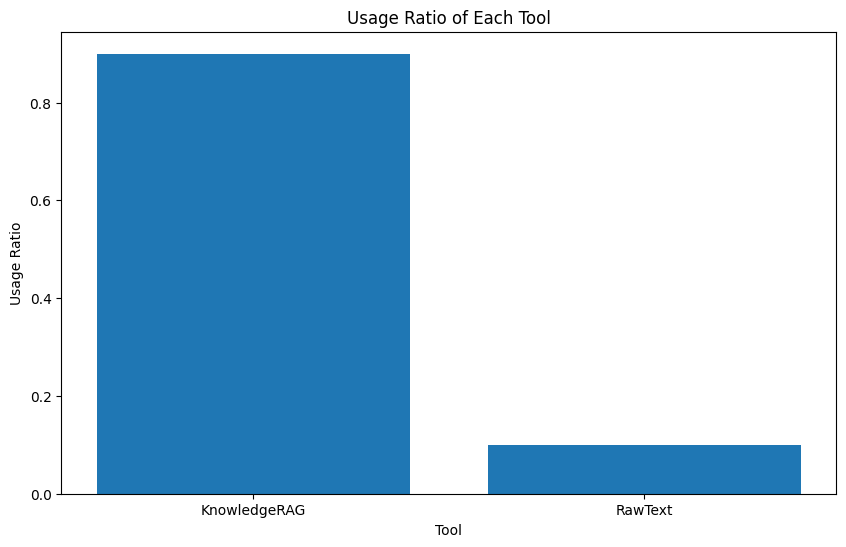

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

tool_usage_counts = {k: v / sum(tool_usage_counts.values()) for k, v in tool_usage_counts.items()}
tool_usage_df = pd.DataFrame(list(tool_usage_counts.items()), columns=["Tool", "Usage_Count"])

plt.figure(figsize=(10, 6))
plt.bar(tool_usage_df["Tool"], tool_usage_df["Usage_Count"])
plt.xlabel("Tool")
plt.ylabel("Usage Ratio")
plt.title("Usage Ratio of Each Tool")
plt.show()